GROUP DETAILS:-

In [1]:
# Group Number: 
#   2
# Group Members: 
#   20CS10053 SARITA SINGH
#   22CS60R21 SHWETA KUMARI
#   19EE10039 MANSI UNIYAL
# Project Number: 
#   CCNN 
# Project Title: 
#   Covid Case Prediction using Artificial Neural Networks

IMPORTING LIBRARIES:-

In [2]:
import csv
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## READING DATA:-

In [3]:
# creating a blank dataframe to store the scores
performances = pd.DataFrame([],columns=['accuracy','learning_rate','model'])

In [4]:
# read csv file into list and convert elements to int
with open('covid_small.csv', 'r') as read_obj:
	csv_reader = csv.reader(read_obj)
	str_data = list(csv_reader)[1:]
	
	m1 = {'2': 0, '1': 1, '97': 2, '98': 2, '99': 2}
	m2 = {'1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 0, '7': 0}
	'''
	# View data distribution
	l1 = np.transpose(str_data)
	for i, row in enumerate(l1):
		if i in [0, 2, 3, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
			print("Row:", i)
			print(collections.Counter(row))
	'''
	
	dataset = [[
					m1.get(i[2], i[2]),
					m1.get(i[3], i[3]),
					m1.get(i[6], i[6]),
					m1.get(i[8], i[8]),
					m1.get(i[9], i[9]),
					m1.get(i[10], i[10]),
					m1.get(i[11], i[11]),
					m1.get(i[12], i[12]),
					m1.get(i[13], i[13]),
					m1.get(i[14], i[14]),
					m1.get(i[15], i[15]),
					m1.get(i[16], i[16]),
					m1.get(i[17], i[17]),
					m1.get(i[18], i[18]),
					m2.get(i[19], i[19]),
				] for i in str_data]

1. DIVIDING INTO TRAIN TEST SET:-

In [5]:
# visualizing the data
dataset[:5]

[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [6]:
# separate labels and features for each data item
X, y = [row[:-1] for row in dataset], [row[-1] for row in dataset]
X, y = shuffle(X, y, random_state=0) # randomly shuffling the data

# dividing into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=4)

In [7]:
#  function for dataset creation
class MyDataset(Dataset):
	def __init__(self, data, targets):
		self.data = torch.FloatTensor(data)
		self.targets = torch.LongTensor(targets)
		
	def __getitem__(self, index):
		x = self.data[index]
		y = self.targets[index]
		return x, y
	
	def __len__(self):
		return len(self.data)

In [8]:
# initializing train and test dataset
batch_size = 128
train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
def plot_curves(acc, loss, epochs_list):
  """
  takes input of list of accuracy scores and loss value along with the epochs to plot 
  """
  fig, ax = plt.subplots(1, 2, figsize=(12,3))
  ax[0].plot(epochs_list, acc)
  ax[0].set_title("accuracy")
  ax[1].plot(epochs_list, loss)
  ax[1].set_title("loss")
  plt.show()


## nn architecture from scratch

In [14]:
class Neural_Network_architecture(): #multi layered neural network with many layers
    def __init__(self, layers, learning_rate, activation, epochs):
        #intitializing the parameters for later use
        self.params = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        # self.loss = []
        # self.accuracy = []
        self.testloss = []
        self.testaccuracy = []
        self.layers = layers
        self.X = None
        self.y = None
        self.activation = activation
                
    def initialize_wts(self):
        # initialise random number generator
        np.random.seed(100) 
        self.params['W1'] = np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1']  =np.random.randn(self.layers[1],)
        if len(self.layers)==3: # for 1 hidden layer
          self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
          self.params['b2'] = np.random.randn(self.layers[2],)
    
    def relu_layer(self, x): # relu activation function
        return np.maximum(0, x)

    def sigmoid_layer(self, x): # sigmoid activation function
        return 1/(1 + np.exp(-x))
        
    def relu_prime(self, x): # derrivative of relu activation function
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def clipp(self, x): # clipping to avoid nan values
      epsilon = 0.0000000001
      return np.maximum(x, epsilon)

    def cross_entropy_loss(self, y, yhat):
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.clipp(yhat) 
        yhat_inv = self.clipp(yhat_inv) 

        loss = (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return -1.0/len(y) * loss
    
    def calc_accuracy(self, y, yhat): # calculating percentage accuracy 
        acc_val = sum(y == yhat) / len(y) * 100.0
        return acc_val

    def frwd_prop(self): # predicting the valye using the parametrs and saving layers        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        if len(self.layers)==3: # 1 hidden layer
          if self.activation=="sigmoid":
            A1 = self.sigmoid_layer(Z1)
          if self.activation=="relu":
            A1 = self.relu_layer(Z1)
          Z2 = A1.dot(self.params['W2']) + self.params['b2']
          yhat = self.relu_layer(Z2) # output layer
        else:
          yhat = self.relu_layer(Z1) # output layer
        loss = self.cross_entropy_loss(self.y,yhat)

        # saving parameters     
        self.params['Z1'] = Z1
        if len(self.layers)==3:
          self.params['Z2'] = Z2
          self.params['A1'] = A1
        return yhat, loss

    def backwrd_prop(self,yhat):
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        # partial derrivative of cross entropy loss
        d_loss_yhat = np.divide(y_inv, self.clipp(yhat_inv)) - np.divide(self.y, self.clipp(yhat))
        if len(self.layers)==3:
          # partial derrivative of relu output activation layer
          d_loss_z2 = d_loss_yhat * self.relu_prime(self.params['Z2']) 
          d_loss_A1 = d_loss_z2.dot(self.params['W2'].T)
          d_loss_w2 = self.params['A1'].T.dot(d_loss_z2) # delta values for 1 hidden layer weights
          d_loss_b2 = np.sum(d_loss_z2, axis=0, keepdims=True)

          if self.activation=="sigmoid":
            # partial derrivative of sigmoid activation layer 1 hidden layer
            d_loss_sig = self.params['Z1'] * (1-self.params['Z1'])
          else:
            # partial derrivative of relu activation layer 1 hidden layer
            d_loss_sig = self.relu_prime(self.params['Z1'])
          d_loss_z1 = d_loss_A1 * d_loss_sig
          d_loss_w1 = self.X.T.dot(d_loss_z1) # delta values for input weights
          d_loss_b1 = np.sum(d_loss_z1, axis=0, keepdims=True)

          # updating weights and bias
          self.params['W1'] = self.params['W1'] - self.learning_rate * d_loss_w1
          self.params['b1'] = self.params['b1'] - self.learning_rate * d_loss_b1
          self.params['b2'] = self.params['b2'] - self.learning_rate * d_loss_b2
          self.params['W2'] = self.params['W2'] - self.learning_rate * d_loss_w2
       
        else:
          # 0 hidden layers
          # partial derrivative of relu output activation layer
          d_loss_z1 = d_loss_yhat * self.relu_prime(self.params['Z1']) 
          d_loss_w1 = self.X.T.dot(d_loss_z1) # delta values for input weights
          d_loss_b1 = np.sum(d_loss_z1, axis=0, keepdims=True)

          # updating weights and bias
          self.params['W1'] = self.params['W1'] - self.learning_rate * d_loss_w1
          self.params['b1'] = self.params['b1'] - self.learning_rate * d_loss_b1

    def training(self, train_dataset, test_dataset): # training the neural network
        self.initialize_wts() #initialize weights and bias

        for i in range(self.epochs): # for each epoch
            # losses, accuracyper = 0, 0 # initializing for calculating average loss and accuracy per epoch over batches
            numbatches = len(train_dataset) # number of batches = number of training sample/size of each batch(128)
            for (X,y) in train_dataset: # for each sample within the batch
              self.X = X.numpy()
              self.y = y.numpy().reshape([-1,1])
              yhat, loss = self.frwd_prop()
              self.backwrd_prop(yhat) # updating parameters
              # losses += loss
              # accuracyper += self.calc_accuracy(self.y, yhat)
            # self.loss.append(losses/numbatches) # saving the averaged loss and accuracy per epoch
            # self.accuracy.append(accuracyper/numbatches)
            
            losses, accuracyper = 0, 0 # initializing for calculating average loss and accuracy per epoch over batches
            numbatches = len(test_dataset) # number of batches = number of test sample/size of each batch(128)
            for (X,y) in test_dataset: # for each sample within the batch
              self.X = X.numpy()
              self.y = y.numpy().reshape([-1,1])
              yhat = self.predict(self.X) # predicting the values for test data
              losses += self.cross_entropy_loss(self.y, yhat)
              accuracyper += self.calc_accuracy(self.y, yhat)
            self.testloss.append(losses/numbatches) # saving the averaged loss and accuracy per epoch
            self.testaccuracy.append(accuracyper/numbatches)

    def predict(self, X): # predicting for new data using saved parameters
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        if len(self.layers)==3: # 1 hidden layer
          if self.activation=="relu":
            A1 = self.relu_layer(Z1)
          else:
            A1 = self.sigmoid_layer(Z1)
          Z2 = A1.dot(self.params['W2']) + self.params['b2']
          pred = self.relu_layer(Z2)
        else:
          pred = self.relu_layer(Z1) # output layer
        return np.round(pred) 

### 0 hidden layers

Training done for learning rate of: 0.001


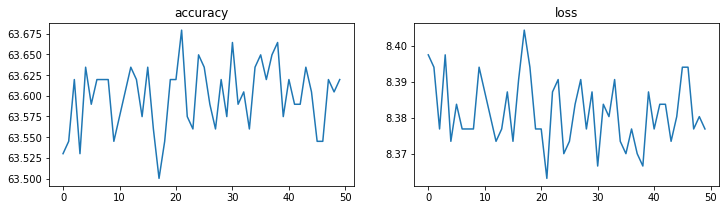

[63.67933917] %


In [15]:
# defining training parameters
epochs = 50
learning_rate=0.001

# initializing a new neural network
model = Neural_Network_architecture(layers=[14,1], learning_rate=learning_rate, activation="relu", epochs=epochs)
model.training(train_dataloader, test_dataloader) # train the model

pred = model.predict(np.array(X_test))
print("Training done for learning rate of:", np.round(learning_rate,5))
max_acc=max(model.testaccuracy)
plot_curves(model.testaccuracy, model.testloss, range(epochs))
print(max_acc,"%")

In [16]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame([max_acc], index=[learning_rate], columns=['accuracy'])
results

accuracy
0.001  63.679339

In [17]:
results['model']="(scratch)0 HIDDEN LAYERS"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                     model
0     0.001      63.679339  (scratch)0 HIDDEN LAYERS

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [18]:
# prediction and metric scores
y_pred = model.predict(np.array(X_test))
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12719
           1       1.00      0.00      0.00      7281

    accuracy                           0.64     20000
   macro avg       0.82      0.50      0.39     20000
weighted avg       0.77      0.64      0.49     20000



### 1 hidden layers(32-relu)

Training done for learning rate of: 0.001


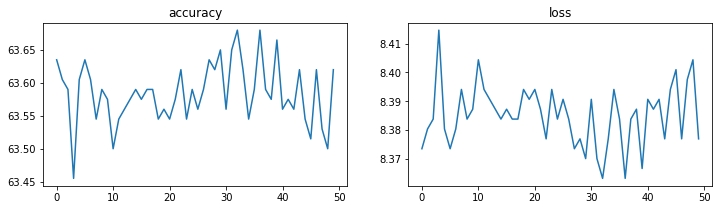

[63.67933917] %


In [19]:
# defining training parameters
epochs = 50
learning_rate=0.001

# initializing a new neural network
model = Neural_Network_architecture(layers=[14,32,1], learning_rate=learning_rate, activation="relu", epochs=epochs)
model.training(train_dataloader, test_dataloader) # train the model

pred = model.predict(np.array(X_test))
print("Training done for learning rate of:", np.round(learning_rate,5))
max_acc=max(model.testaccuracy)
plot_curves(model.testaccuracy, model.testloss, range(epochs))
print(max_acc,"%")

In [20]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame([max_acc], index=[learning_rate], columns=['accuracy'])
results

accuracy
0.001  63.679339

In [21]:
results['model']="(scratch)1 HIDDEN LAYERS(32-relu)"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                              model
0     0.001      63.679339           (scratch)0 HIDDEN LAYERS
0     0.001      63.679339  (scratch)1 HIDDEN LAYERS(32-relu)

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [22]:
# prediction and metric scores
y_pred = model.predict(np.array(X_test))
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12719
           1       1.00      0.00      0.00      7281

    accuracy                           0.64     20000
   macro avg       0.82      0.50      0.39     20000
weighted avg       0.77      0.64      0.49     20000



### 1 hidden layers(32-sigmoid)

<ipython-input-14-00612da89980>:29: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Training done for learning rate of: 0.001


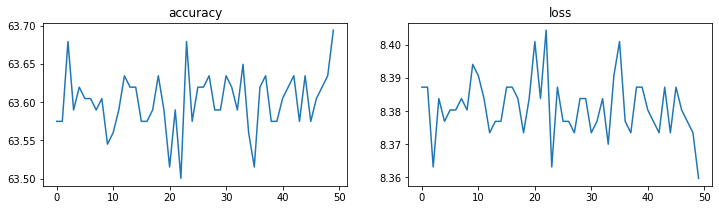

[63.69426752] %


In [23]:
# defining training parameters
epochs = 50
learning_rate=0.001

# initializing a new neural network
model = Neural_Network_architecture(layers=[14,32,1], learning_rate=learning_rate, activation="sigmoid", epochs=epochs)
model.training(train_dataloader, test_dataloader) # train the model

pred = model.predict(np.array(X_test))
print("Training done for learning rate of:", np.round(learning_rate,5))
max_acc=max(model.testaccuracy)
plot_curves(model.testaccuracy, model.testloss, range(epochs))
print(max_acc,"%")

In [24]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame([max_acc], index=[learning_rate], columns=['accuracy'])
results

accuracy
0.001  63.694268

In [25]:
results['model']="(scratch)1 HIDDEN LAYERS(32-sigmoid)"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0     0.001      63.679339              (scratch)0 HIDDEN LAYERS
0     0.001      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0     0.001      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [26]:
# prediction and metric scores
y_pred = model.predict(np.array(X_test))
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12719
           1       1.00      0.00      0.00      7281

    accuracy                           0.64     20000
   macro avg       0.82      0.50      0.39     20000
weighted avg       0.77      0.64      0.49     20000



<ipython-input-14-00612da89980>:29: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


### 1 hidden layers(64-relu)

Training done for learning rate of: 0.001


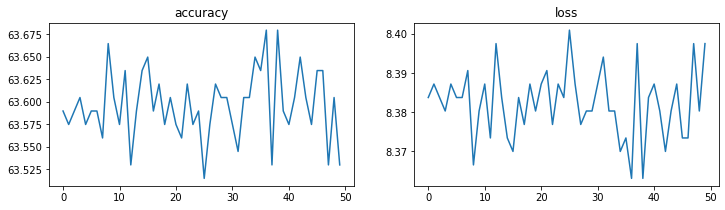

[63.67933917] %


In [27]:
# defining training parameters
epochs = 50
learning_rate=0.001

# initializing a new neural network
model = Neural_Network_architecture(layers=[14,64,1], learning_rate=learning_rate, activation="relu", epochs=epochs)
model.training(train_dataloader, test_dataloader) # train the model

pred = model.predict(np.array(X_test))
print("Training done for learning rate of:", np.round(learning_rate,5))
max_acc=max(model.testaccuracy)
plot_curves(model.testaccuracy, model.testloss, range(epochs))
print(max_acc,"%")

In [28]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame([max_acc], index=[learning_rate], columns=['accuracy'])
results

accuracy
0.001  63.679339

In [29]:
results['model']="(scratch)1 HIDDEN LAYERS(64-relu)"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0     0.001      63.679339              (scratch)0 HIDDEN LAYERS
0     0.001      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0     0.001      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0     0.001      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [30]:
# prediction and metric scores
y_pred = model.predict(np.array(X_test))
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12719
           1       1.00      0.00      0.00      7281

    accuracy                           0.64     20000
   macro avg       0.82      0.50      0.39     20000
weighted avg       0.77      0.64      0.49     20000



### 1 hidden layers(64-relu)

<ipython-input-14-00612da89980>:29: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Training done for learning rate of: 0.001


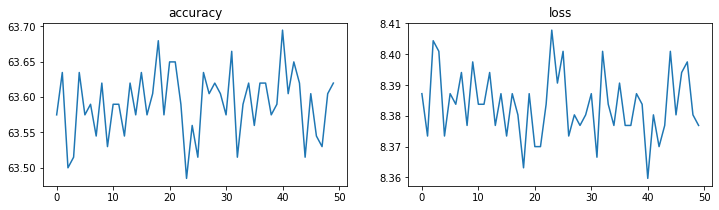

[63.69426752] %


In [31]:
# defining training parameters
epochs = 50
learning_rate=0.001

# initializing a new neural network
model = Neural_Network_architecture(layers=[14,64,1], learning_rate=learning_rate, activation="sigmoid", epochs=epochs)
model.training(train_dataloader, test_dataloader) # train the model

pred = model.predict(np.array(X_test))
print("Training done for learning rate of:", np.round(learning_rate,5))
max_acc=max(model.testaccuracy)
plot_curves(model.testaccuracy, model.testloss, range(epochs))
print(max_acc,"%")

In [32]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame([max_acc], index=[learning_rate], columns=['accuracy'])
results

accuracy
0.001  63.694268

In [33]:
results['model']="(scratch)1 HIDDEN LAYERS(64-sigmoid)"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0     0.001      63.679339              (scratch)0 HIDDEN LAYERS
0     0.001      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0     0.001      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0     0.001      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0     0.001      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [34]:
# prediction and metric scores
y_pred = model.predict(np.array(X_test))
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12719
           1       1.00      0.00      0.00      7281

    accuracy                           0.64     20000
   macro avg       0.82      0.50      0.39     20000
weighted avg       0.77      0.64      0.49     20000



<ipython-input-14-00612da89980>:29: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


## 2. NEURAL NETWORK USING PYTORCH:-

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
	"""
	function takes the input of training dataset, model, loss function and optimizer
	"""
	size = len(dataloader.dataset)
	for batch, (X, y) in enumerate(dataloader):
		# Compute prediction and loss
		pred = model(X.to(device))
		loss = loss_fn(pred, y.to(device))

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 100 == 0:
			loss, current = loss.item(), (batch + 1) * len(X)
			#print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [36]:
def test_loop(dataloader, model, loss_fn):
	"""
	function takes the input of test dataset, trained model and loss function (as metric for learning)
	"""
	size = len(dataloader.dataset)
	num_batches = len(dataloader)
	test_loss, correct = 0, 0

	with torch.no_grad(): # while the weights are not being trained/updated
		for X, y in dataloader:
			pred = model(X.to(device))
			test_loss += loss_fn(pred, y.to(device)).item()
			correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

	test_loss /= num_batches
	correct /= size
	#print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
	return test_loss,correct

In [37]:
# custom neural network built with variable architecture flexibility
class customNeuralNetwork(nn.Module):
	def __init__(self, num_hidden, num_nodes, activation):
		super(customNeuralNetwork, self).__init__()
		self.num_hidden = num_hidden
		self.activation = activation
		if(num_hidden):
			self.l1 = nn.Linear(14, num_nodes)
			self.l2 = nn.Linear(num_nodes, 2)
		else:
			self.l1 = nn.Linear(14, 2)

	def forward(self, x):
		x = self.l1(x)
		if(self.num_hidden):
			if(self.activation=="sigmoid"):
				x = torch.sigmoid(x)
			else:
				x = F.relu(x)
			x = self.l2(x)
		return F.relu(x)

3. EXPERIMENTS FOR VARIATION WRT LEARNING RATE:-

### i. 0 HIDDEN LAYERS

Training done for learning rate of: 1e-05


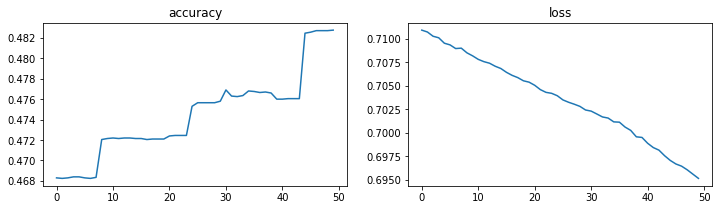

Training done for learning rate of: 0.0001


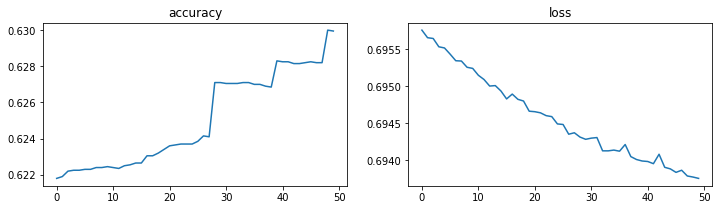

Training done for learning rate of: 0.001


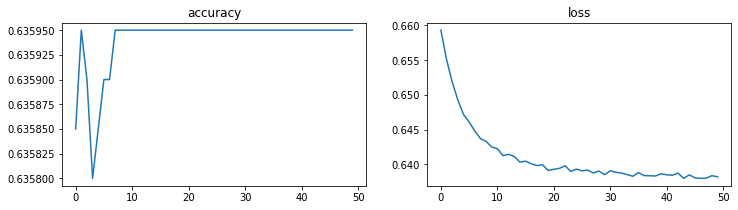

Training done for learning rate of: 0.01


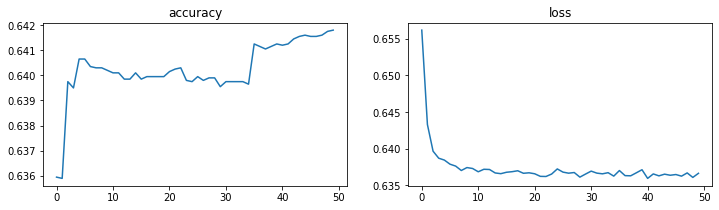

Training done for learning rate of: 0.1


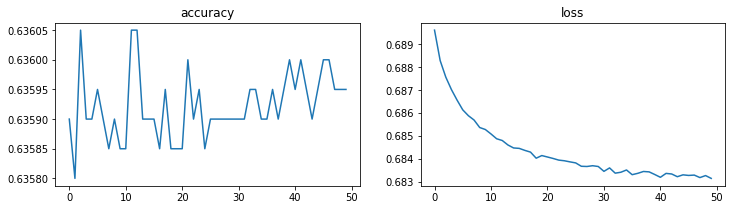

The maximum accuracy is: 0.640247


In [38]:
# defining training parameters
epochs = 50
lr=[]
acc_lr=[]
loss_lr=[]
max_acc=0
max_lr=0
learning_rate=0.000001

# iterating for each learning rate value
for i in range(5):
  learning_rate *= 10.0
  model = customNeuralNetwork(0, 0, "sigmoid") # initializing a new neural network
  model = model.to(device)
  # defining loss functions and optimizers to train with
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  acc=[]
  loss=[]
  for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # calculating the test scores and appending for plotting
    test_loss, correct = test_loop(test_dataloader, model, loss_fn)
    acc.append(correct)
    loss.append(test_loss)

  print("Training done for learning rate of:", np.round(learning_rate,5))
  acc_lr.append(sum(acc)/len(acc))
  lr.append(learning_rate)
  loss_lr.append(sum(loss)/len(loss))

  if max_acc<=sum(acc)/len(acc):
    max_acc=sum(acc)/len(acc)
    max_lr=learning_rate
    best_model=model
  plot_curves(acc,loss,range(epochs))
print("The maximum accuracy is:", max_acc)

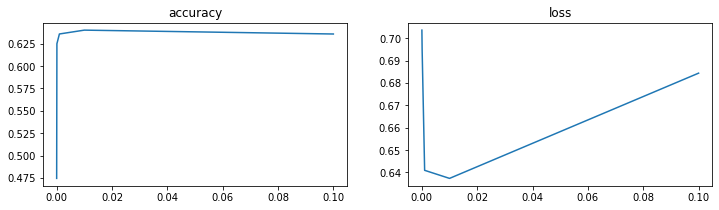

In [39]:
# plotting variation of accuracy and losses wrt changing learning rate
plot_curves(acc_lr, loss_lr, lr)

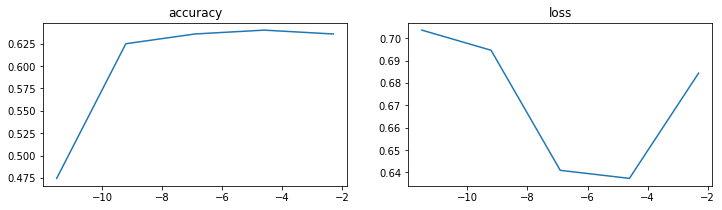

curves plotted in logarithmic scale


In [40]:
plot_curves(acc_lr, loss_lr, np.log(np.array(lr))) 
print("curves plotted in logarithmic scale")

In [41]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame(acc_lr, index=lr, columns=['accuracy'])
results['accuracy'] *= 100
results

accuracy
0.00001   47.4418
0.00010   62.5034
0.00100   63.5940
0.01000   64.0247
0.10000   63.5922

In [42]:
# storing the results in final table for analysis
ans = results.sort_values(by = 'accuracy').iloc[-1,:] #best model
print("the best model has average", ans, "value of learning rate")

the best model has average accuracy    64.0247
Name: 0.01, dtype: float64 value of learning rate


In [43]:
results['model']="0 HIDDEN LAYERS"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0   0.00100      63.679339              (scratch)0 HIDDEN LAYERS
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)
0   0.00001      47.441800                       0 HIDDEN LAYERS
1   0.00010      62.503400                       0 HIDDEN LAYERS
2   0.00100      63.594000                       0 HIDDEN LAYERS
3   0.01000      64.024700                       0 HIDDEN LAYERS
4   0.10000      63.592200                       0 HIDDEN LAYERS

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [44]:
# prediction and metric scores
model = best_model
y_pred = []
with torch.no_grad():
	for X, y in test_dataloader:
		y = model(X.to(device)).argmax(1).cpu().tolist()
		y_pred.extend(y)
	
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.96      0.76     12719
           1       0.38      0.05      0.08      7281

    accuracy                           0.63     20000
   macro avg       0.51      0.50      0.42     20000
weighted avg       0.54      0.63      0.52     20000



### ii. 1 HIDDEN LAYER (32 NODES)

#### sigmoid activation

Training done for learning rate of: 1e-05


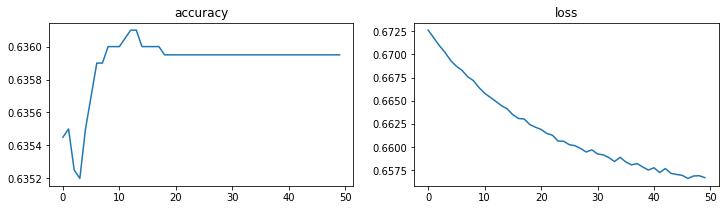

Training done for learning rate of: 0.0001


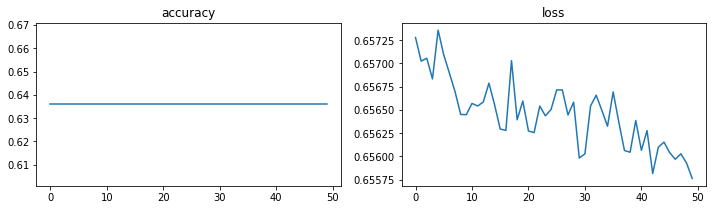

Training done for learning rate of: 0.001


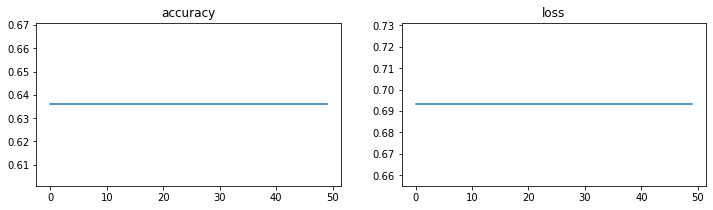

Training done for learning rate of: 0.01


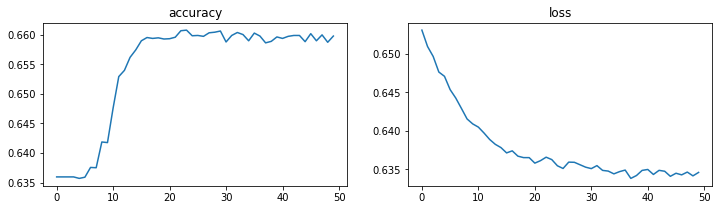

Training done for learning rate of: 0.1


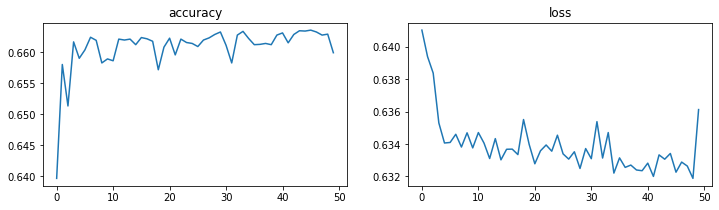

The maximum accuracy is: 0.6608839999999999


In [45]:
# defining training parameters
epochs = 50
lr=[]
acc_lr=[]
loss_lr=[]
max_acc=0
max_lr=0
learning_rate=0.000001

# iterating for each learning rate value
for i in range(5):
  learning_rate *= 10.0
  model = customNeuralNetwork(1, 32, "sigmoid") # initializing a new neural network
  model = model.to(device)
  # defining loss functions and optimizers to train with
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  acc=[]
  loss=[]
  for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # calculating the test scores and appending for plotting
    test_loss, correct = test_loop(test_dataloader, model, loss_fn)
    acc.append(correct)
    loss.append(test_loss)

  print("Training done for learning rate of:", np.round(learning_rate,5))
  acc_lr.append(sum(acc)/len(acc))
  lr.append(learning_rate)
  loss_lr.append(sum(loss)/len(loss))
  
  if max_acc<=sum(acc)/len(acc):
    max_acc=sum(acc)/len(acc)
    max_lr=learning_rate
    best_model=model
  plot_curves(acc,loss,range(epochs))
print("The maximum accuracy is:", max_acc)

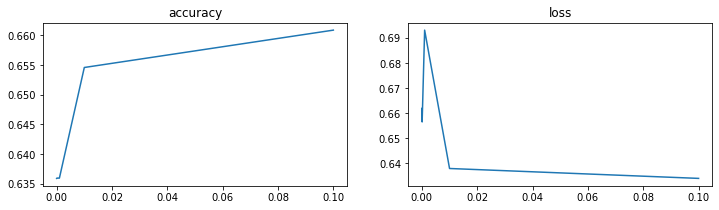

In [46]:
# plotting variation of accuracy and losses wrt changing learning rate
plot_curves(acc_lr, loss_lr, lr)

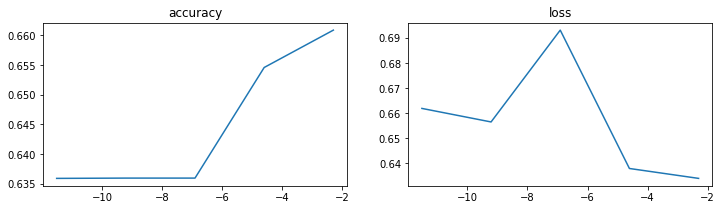

curves plotted in logarithmic scale


In [47]:
plot_curves(acc_lr, loss_lr, np.log(np.array(lr))) 
print("curves plotted in logarithmic scale")

In [48]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame(acc_lr, index=lr, columns=['accuracy'])
results['accuracy'] *= 100
results

accuracy
0.00001   63.5901
0.00010   63.5950
0.00100   63.5950
0.01000   65.4589
0.10000   66.0884

In [49]:
# storing the results in final table for analysis
ans = results.sort_values(by = 'accuracy').iloc[-1,:] #best model
print("the best model has average", ans, "value of learning rate")

the best model has average accuracy    66.0884
Name: 0.1, dtype: float64 value of learning rate


In [50]:
results['model']="1 HIDDEN (32 NODES) SIGMOID"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0   0.00100      63.679339              (scratch)0 HIDDEN LAYERS
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)
0   0.00001      47.441800                       0 HIDDEN LAYERS
1   0.00010      62.503400                       0 HIDDEN LAYERS
2   0.00100      63.594000                       0 HIDDEN LAYERS
3   0.01000      64.024700                       0 HIDDEN LAYERS
4   0.10000      63.592200                       0 HIDDEN LAYERS
0   0.00001      63.590100           1 HIDDEN (32 NODES) SIGMOID
1   0.00010      63.595000           1 HIDDEN (32 NODES) SIGMOID
2   0.00100      63.595000           1 HIDDEN (32 NODES) SIGMOID
3   0.01000      65.458900           1 HIDDEN (32 NODES) SIGMOID
4   0.10000      66.088400           1 HIDDEN (32 NODES) SIGMOID

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [51]:
# prediction and metric scores
model = best_model
y_pred = []
with torch.no_grad():
	for X, y in test_dataloader:
		y = model(X.to(device)).argmax(1).cpu().tolist()
		y_pred.extend(y)
	
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.63      0.83      0.72     12719
           1       0.36      0.17      0.23      7281

    accuracy                           0.59     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.53      0.59      0.54     20000



#### relu activation

Training done for learning rate of: 1e-05


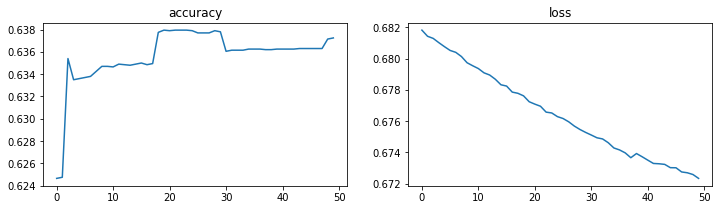

Training done for learning rate of: 0.0001


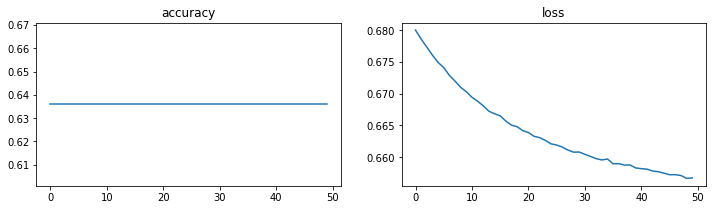

Training done for learning rate of: 0.001


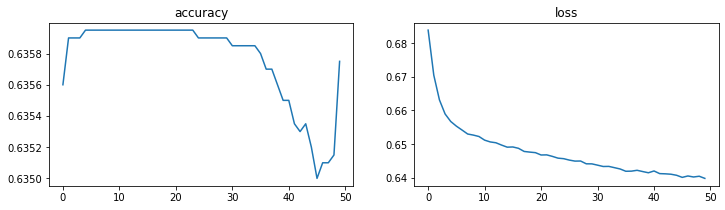

Training done for learning rate of: 0.01


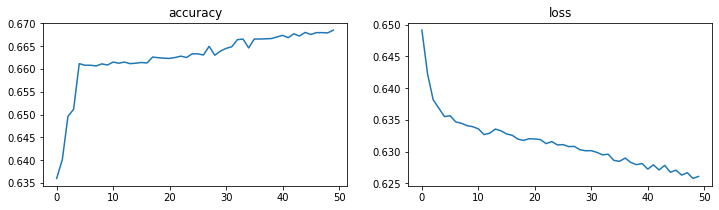

Training done for learning rate of: 0.1


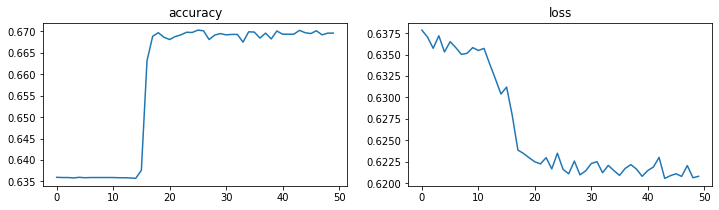

The maximum accuracy is: 0.6625550000000002


In [52]:
# defining training parameters
epochs = 50
lr=[]
acc_lr=[]
loss_lr=[]
max_acc=0
max_lr=0
learning_rate=0.000001

# iterating for each learning rate value
for i in range(5):
  learning_rate *= 10.0
  model = customNeuralNetwork(1, 32, "relu") # initializing a new neural network
  model = model.to(device)
  # defining loss functions and optimizers to train with
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  acc=[]
  loss=[]
  for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # calculating the test scores and appending for plotting
    test_loss, correct = test_loop(test_dataloader, model, loss_fn)
    acc.append(correct)
    loss.append(test_loss)

  print("Training done for learning rate of:", np.round(learning_rate,5))
  acc_lr.append(sum(acc)/len(acc))
  lr.append(learning_rate)
  loss_lr.append(sum(loss)/len(loss))
  
  if max_acc<=sum(acc)/len(acc):
    max_acc=sum(acc)/len(acc)
    max_lr=learning_rate
    best_model=model
  plot_curves(acc,loss,range(epochs))
print("The maximum accuracy is:", max_acc)

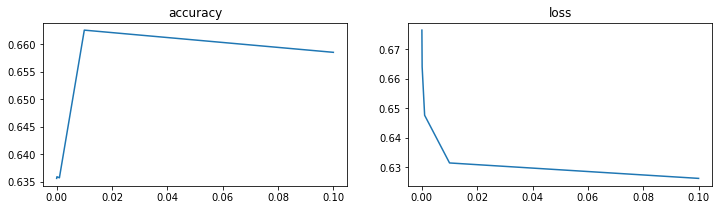

In [53]:
# plotting variation of accuracy and losses wrt changing learning rate
plot_curves(acc_lr, loss_lr, lr)

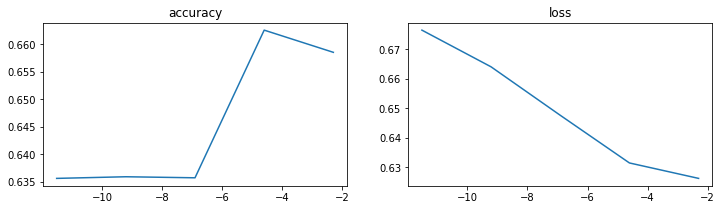

curves plotted in logarithmic scale


In [54]:
plot_curves(acc_lr, loss_lr, np.log(np.array(lr))) 
print("curves plotted in logarithmic scale")

In [55]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame(acc_lr, index=lr, columns=['accuracy'])
results['accuracy'] *= 100
results

accuracy
0.00001   63.5653
0.00010   63.5950
0.00100   63.5761
0.01000   66.2555
0.10000   65.8527

In [56]:
# storing the results in final table for analysis
ans = results.sort_values(by = 'accuracy').iloc[-1,:] #best model
print("the best model has average", ans, "value of learning rate")

the best model has average accuracy    66.2555
Name: 0.01, dtype: float64 value of learning rate


In [57]:
results['model'] = "1 HIDDEN (32 NODES) RELU"
results = results.reset_index()
results.columns = ['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0   0.00100      63.679339              (scratch)0 HIDDEN LAYERS
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)
0   0.00001      47.441800                       0 HIDDEN LAYERS
1   0.00010      62.503400                       0 HIDDEN LAYERS
2   0.00100      63.594000                       0 HIDDEN LAYERS
3   0.01000      64.024700                       0 HIDDEN LAYERS
4   0.10000      63.592200                       0 HIDDEN LAYERS
0   0.00001      63.590100           1 HIDDEN (32 NODES) SIGMOID
1   0.00010      63.595000           1 HIDDEN (32 NODES) SIGMOID
2   0.00100      63.595000           1 HIDDEN (32 NODES) SIGMOID
3   0.01000      65.458900           1 HIDDEN (32 NODES) SIGMOID
4   0.10000      66.088400           1 HIDDEN (32 NODES) SIGMOID
0   0.00001      63.565300              1 HIDDEN (32 NODES) RELU
1   0.00010      63.595000              1 HIDDEN (32 NODES) RELU
2   0.00100      63.576100              1 HIDDEN (32 NODES) RELU
3   0.01000      66.255500              1 HIDDEN (32 NODES) RELU
4   0.10000      65.852700              1 HIDDEN (32 NODES) RELU

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [58]:
# prediction and metric scores
model = best_model
y_pred = []
with torch.no_grad():
	for X, y in test_dataloader:
		y = model(X.to(device)).argmax(1).cpu().tolist()
		y_pred.extend(y)
	
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.85      0.73     12719
           1       0.37      0.15      0.21      7281

    accuracy                           0.60     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.54      0.60      0.54     20000



### iii. 1 HIDDEN LAYER (64 NODES)

#### sigmoid activation

Training done for learning rate of: 1e-05


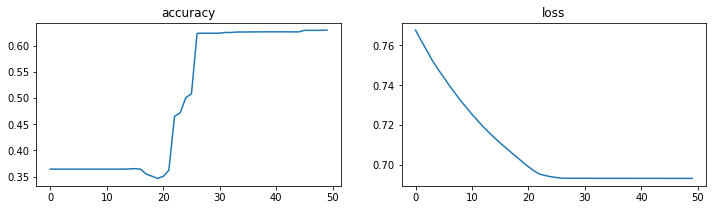

Training done for learning rate of: 0.0001


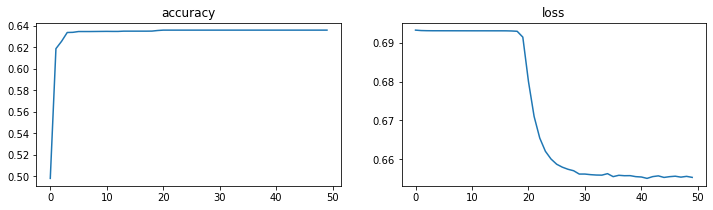

Training done for learning rate of: 0.001


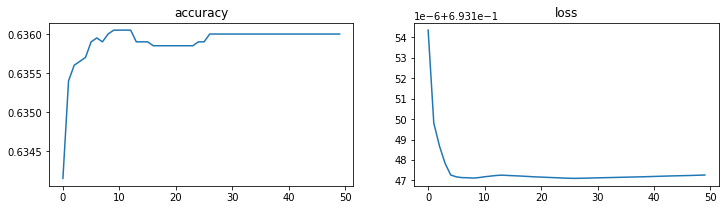

Training done for learning rate of: 0.01


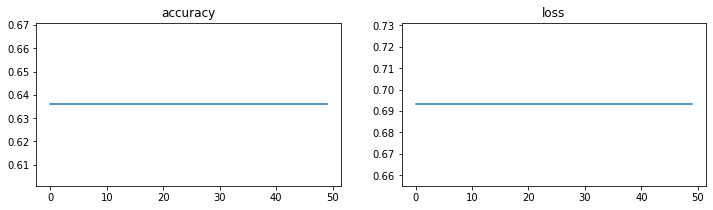

Training done for learning rate of: 0.1


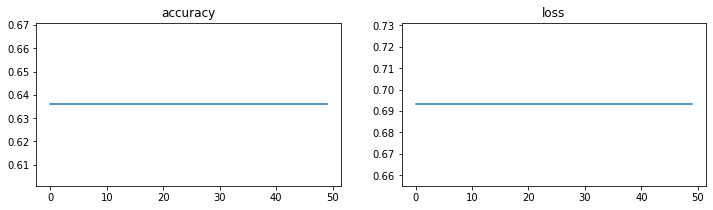

The maximum accuracy is: 0.6359500000000005


In [59]:
# defining training parameters
epochs = 50
lr=[]
acc_lr=[]
loss_lr=[]
max_acc=0
max_lr=0
learning_rate=0.000001

# iterating for each learning rate value
for i in range(5):
  learning_rate *= 10.0
  model = customNeuralNetwork(1, 64, "sigmoid") # initializing a new neural network
  model = model.to(device)
  # defining loss functions and optimizers to train with
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  acc=[]
  loss=[]
  for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # calculating the test scores and appending for plotting
    test_loss, correct = test_loop(test_dataloader, model, loss_fn)
    acc.append(correct)
    loss.append(test_loss)

  print("Training done for learning rate of:", np.round(learning_rate,5))
  acc_lr.append(sum(acc)/len(acc))
  lr.append(learning_rate)
  loss_lr.append(sum(loss)/len(loss))
  
  if max_acc<=sum(acc)/len(acc):
    max_acc=sum(acc)/len(acc)
    max_lr=learning_rate
    best_model=model
  plot_curves(acc,loss,range(epochs))
print("The maximum accuracy is:", max_acc)

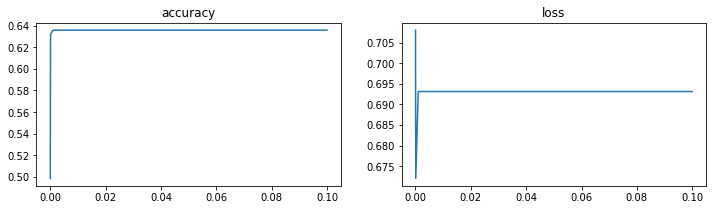

In [60]:
# plotting variation of accuracy and losses wrt changing learning rate
plot_curves(acc_lr, loss_lr, lr)

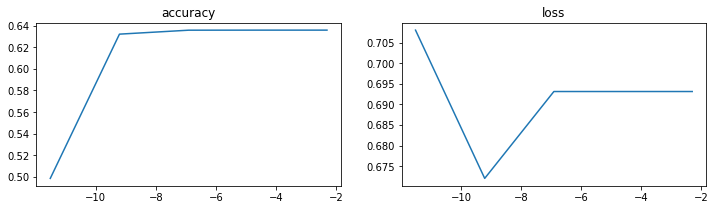

curves plotted in logarithmic scale


In [61]:
plot_curves(acc_lr, loss_lr, np.log(np.array(lr))) 
print("curves plotted in logarithmic scale")

In [62]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame(acc_lr, index=lr, columns=['accuracy'])
results['accuracy'] *= 100
results

accuracy
0.00001   49.8446
0.00010   63.2235
0.00100   63.5895
0.01000   63.5950
0.10000   63.5950

In [63]:
# storing the results in final table for analysis
ans = results.sort_values(by = 'accuracy').iloc[-1,:] #best model
print("the best model has average", ans, "value of learning rate")

the best model has average accuracy    63.595
Name: 0.1, dtype: float64 value of learning rate


In [64]:
results['model']="1 HIDDEN (64 NODES) SIGMOID"
results = results.reset_index()
results.columns=['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0   0.00100      63.679339              (scratch)0 HIDDEN LAYERS
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)
0   0.00001      47.441800                       0 HIDDEN LAYERS
1   0.00010      62.503400                       0 HIDDEN LAYERS
2   0.00100      63.594000                       0 HIDDEN LAYERS
3   0.01000      64.024700                       0 HIDDEN LAYERS
4   0.10000      63.592200                       0 HIDDEN LAYERS
0   0.00001      63.590100           1 HIDDEN (32 NODES) SIGMOID
1   0.00010      63.595000           1 HIDDEN (32 NODES) SIGMOID
2   0.00100      63.595000           1 HIDDEN (32 NODES) SIGMOID
3   0.01000      65.458900           1 HIDDEN (32 NODES) SIGMOID
4   0.10000      66.088400           1 HIDDEN (32 NODES) SIGMOID
0   0.00001      63.565300              1 HIDDEN (32 NODES) RELU
1   0.00010      63.595000              1 HIDDEN (32 NODES) RELU
2   0.00100      63.576100              1 HIDDEN (32 NODES) RELU
3   0.01000      66.255500              1 HIDDEN (32 NODES) RELU
4   0.10000      65.852700              1 HIDDEN (32 NODES) RELU
0   0.00001      49.844600           1 HIDDEN (64 NODES) SIGMOID
1   0.00010      63.223500           1 HIDDEN (64 NODES) SIGMOID
2   0.00100      63.589500           1 HIDDEN (64 NODES) SIGMOID
3   0.01000      63.595000           1 HIDDEN (64 NODES) SIGMOID
4   0.10000      63.595000           1 HIDDEN (64 NODES) SIGMOID

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [65]:
# prediction and metric scores
model = best_model
y_pred = []
with torch.no_grad():
	for X, y in test_dataloader:
		y = model(X.to(device)).argmax(1).cpu().tolist()
		y_pred.extend(y)
	
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78     12719
           1       1.00      0.00      0.00      7281

    accuracy                           0.64     20000
   macro avg       0.82      0.50      0.39     20000
weighted avg       0.77      0.64      0.49     20000



#### relu activation

Training done for learning rate of: 1e-05


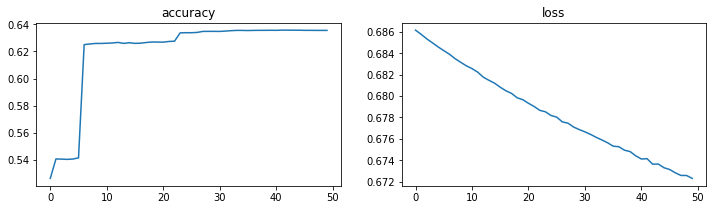

Training done for learning rate of: 0.0001


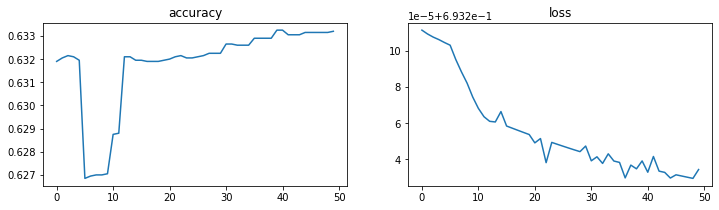

Training done for learning rate of: 0.001


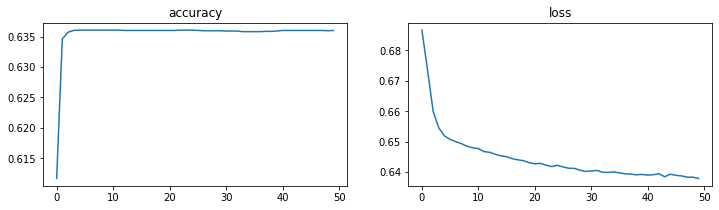

Training done for learning rate of: 0.01


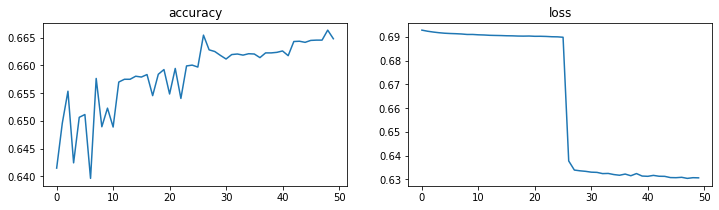

Training done for learning rate of: 0.1


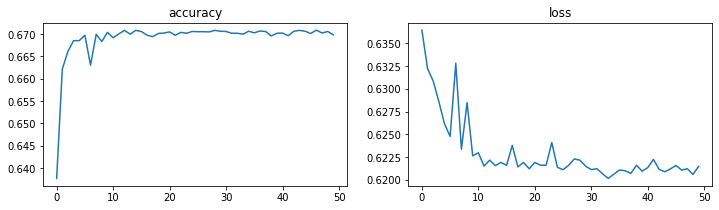

The maximum accuracy is: 0.669144


In [66]:
# defining training parameters
epochs = 50
lr=[]
acc_lr=[]
loss_lr=[]
max_acc=0
max_lr=0
learning_rate=0.000001

# iterating for each learning rate value
for i in range(5):
  learning_rate *= 10.0
  model = customNeuralNetwork(1, 64, "relu") # initializing a new neural network
  model = model.to(device)
  # defining loss functions and optimizers to train with
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  
  acc=[]
  loss=[]
  for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # calculating the test scores and appending for plotting
    test_loss, correct = test_loop(test_dataloader, model, loss_fn)
    acc.append(correct)
    loss.append(test_loss)

  print("Training done for learning rate of:", np.round(learning_rate,5))
  acc_lr.append(sum(acc)/len(acc))
  lr.append(learning_rate)
  loss_lr.append(sum(loss)/len(loss))
  
  if max_acc<=sum(acc)/len(acc):
    max_acc=sum(acc)/len(acc)
    max_lr=learning_rate
    best_model=model
  plot_curves(acc,loss,range(epochs))
print("The maximum accuracy is:", max_acc)

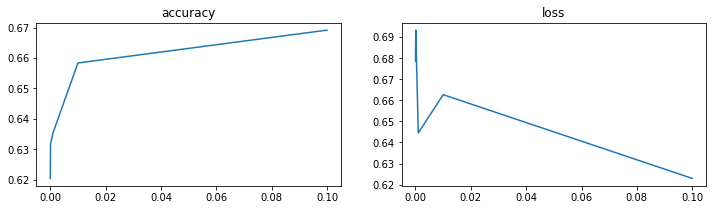

In [67]:
# plotting variation of accuracy and losses wrt changing learning rate
plot_curves(acc_lr, loss_lr, lr)

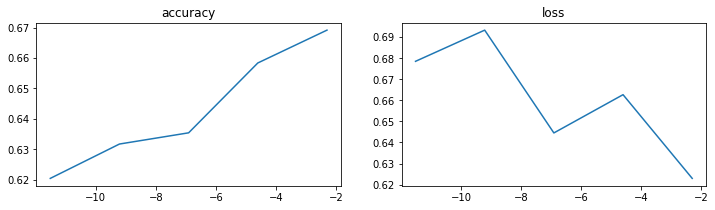

curves plotted in logarithmic scale


In [68]:
plot_curves(acc_lr, loss_lr, np.log(np.array(lr))) 
print("curves plotted in logarithmic scale")

In [69]:
# maximum test accuracy scores obtained in each learning rate
results = pd.DataFrame(acc_lr, index=lr, columns=['accuracy'])
results['accuracy'] *= 100
results

accuracy
0.00001   62.0508
0.00010   63.1779
0.00100   63.5456
0.01000   65.8370
0.10000   66.9144

In [70]:
# storing the results in final table for analysis
ans = results.sort_values(by = 'accuracy').iloc[-1,:] #best model
print("the best model has average", ans, "value of learning rate")

the best model has average accuracy    66.9144
Name: 0.1, dtype: float64 value of learning rate


In [71]:
results['model'] = "1 HIDDEN (64 NODES) RELU"
results = results.reset_index()
results.columns = ['accuracy','learning_rate','model']
performances = pd.concat([performances,results])
performances

accuracy  learning_rate                                 model
0   0.00100      63.679339              (scratch)0 HIDDEN LAYERS
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)
0   0.00001      47.441800                       0 HIDDEN LAYERS
1   0.00010      62.503400                       0 HIDDEN LAYERS
2   0.00100      63.594000                       0 HIDDEN LAYERS
3   0.01000      64.024700                       0 HIDDEN LAYERS
4   0.10000      63.592200                       0 HIDDEN LAYERS
0   0.00001      63.590100           1 HIDDEN (32 NODES) SIGMOID
1   0.00010      63.595000           1 HIDDEN (32 NODES) SIGMOID
2   0.00100      63.595000           1 HIDDEN (32 NODES) SIGMOID
3   0.01000      65.458900           1 HIDDEN (32 NODES) SIGMOID
4   0.10000      66.088400           1 HIDDEN (32 NODES) SIGMOID
0   0.00001      63.565300              1 HIDDEN (32 NODES) RELU
1   0.00010      63.595000              1 HIDDEN (32 NODES) RELU
2   0.00100      63.576100              1 HIDDEN (32 NODES) RELU
3   0.01000      66.255500              1 HIDDEN (32 NODES) RELU
4   0.10000      65.852700              1 HIDDEN (32 NODES) RELU
0   0.00001      49.844600           1 HIDDEN (64 NODES) SIGMOID
1   0.00010      63.223500           1 HIDDEN (64 NODES) SIGMOID
2   0.00100      63.589500           1 HIDDEN (64 NODES) SIGMOID
3   0.01000      63.595000           1 HIDDEN (64 NODES) SIGMOID
4   0.10000      63.595000           1 HIDDEN (64 NODES) SIGMOID
0   0.00001      62.050800              1 HIDDEN (64 NODES) RELU
1   0.00010      63.177900              1 HIDDEN (64 NODES) RELU
2   0.00100      63.545600              1 HIDDEN (64 NODES) RELU
3   0.01000      65.837000              1 HIDDEN (64 NODES) RELU
4   0.10000      66.914400              1 HIDDEN (64 NODES) RELU

4. CLASSIFICATION TABLE FOR BEST MODEL:-

In [72]:
# prediction and metric scores
model = best_model
y_pred = []
with torch.no_grad():
	for X, y in test_dataloader:
		y = model(X.to(device)).argmax(1).cpu().tolist()
		y_pred.extend(y)
	
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73     12719
           1       0.36      0.14      0.20      7281

    accuracy                           0.60     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.53      0.60      0.54     20000



## FINAL TABLE OF OBSERVATIONS

In [73]:
# scores of models sorted in ascending order
performances.sort_values(by = 'accuracy')

accuracy  learning_rate                                 model
0   0.00001      62.050800              1 HIDDEN (64 NODES) RELU
0   0.00001      49.844600           1 HIDDEN (64 NODES) SIGMOID
0   0.00001      47.441800                       0 HIDDEN LAYERS
0   0.00001      63.565300              1 HIDDEN (32 NODES) RELU
0   0.00001      63.590100           1 HIDDEN (32 NODES) SIGMOID
1   0.00010      63.223500           1 HIDDEN (64 NODES) SIGMOID
1   0.00010      63.177900              1 HIDDEN (64 NODES) RELU
1   0.00010      62.503400                       0 HIDDEN LAYERS
1   0.00010      63.595000              1 HIDDEN (32 NODES) RELU
1   0.00010      63.595000           1 HIDDEN (32 NODES) SIGMOID
2   0.00100      63.589500           1 HIDDEN (64 NODES) SIGMOID
2   0.00100      63.576100              1 HIDDEN (32 NODES) RELU
0   0.00100      63.679339              (scratch)0 HIDDEN LAYERS
2   0.00100      63.545600              1 HIDDEN (64 NODES) RELU
2   0.00100      63.594000                       0 HIDDEN LAYERS
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(64-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(64-relu)
0   0.00100      63.694268  (scratch)1 HIDDEN LAYERS(32-sigmoid)
0   0.00100      63.679339     (scratch)1 HIDDEN LAYERS(32-relu)
2   0.00100      63.595000           1 HIDDEN (32 NODES) SIGMOID
3   0.01000      65.458900           1 HIDDEN (32 NODES) SIGMOID
3   0.01000      65.837000              1 HIDDEN (64 NODES) RELU
3   0.01000      64.024700                       0 HIDDEN LAYERS
3   0.01000      66.255500              1 HIDDEN (32 NODES) RELU
3   0.01000      63.595000           1 HIDDEN (64 NODES) SIGMOID
4   0.10000      66.088400           1 HIDDEN (32 NODES) SIGMOID
4   0.10000      65.852700              1 HIDDEN (32 NODES) RELU
4   0.10000      63.592200                       0 HIDDEN LAYERS
4   0.10000      63.595000           1 HIDDEN (64 NODES) SIGMOID
4   0.10000      66.914400              1 HIDDEN (64 NODES) RELU